# Visualizing Activation Distributions of Vision Transformers with Matplotlib

In [1]:
import os
import gc
import torch
from torchvision.transforms import v2
from torchvision import transforms
import torchvision
from copy import deepcopy as copy
from tqdm import tqdm
import numpy as np

import matplotlib.pyplot as plt

In [2]:
def dino_model():
    os.environ['TORCH_HOME'] = './'
    os.environ['TORCH_HUB'] = './'
    # DINOv2 vit-s (14) with registers
    model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitb14_reg')
    # state = model.state_dict()
    # mymodel = vit_small(14, 4)
    # mymodel.load_state_dict(state)
    model.eval()

    return model.to('cpu')

def dino_transforms():
    return v2.Compose(
                    [
                        torchvision.transforms.ToTensor(),
                        transforms.Resize(size=(256, 256), antialias=True),
                        transforms.CenterCrop((224, 224)),
                        transforms.Normalize(
                                            mean=[0.485, 0.456, 0.406],
                                            std=[0.229, 0.224, 0.225]
                                            ),
                    ]
                    )

In [3]:
def get_activation(name):
    activations = []
    def hook(model, input, output):
        activations.append(output.detach().clone()[:, 0].cpu().type(torch.float16))
    return hook, activations


def activationdist(network, test_loader, names, batches, dtype=torch.float32, silent=False):
    network = copy(network)
    network.eval().to(0)
    test_loss = 0
    correct = 0
    test_losses=[]

    dist_dict = {}

    for name in names:
        hook, activations = get_activation(name)
        dist_dict[name] = activations
        getattrrecur(network, name).register_forward_hook(hook)
    
    with torch.no_grad():
        for i, (data, target) in tqdm(enumerate(test_loader)):
            if i >= batches: 
                break
            output = network(data.to(0).type(dtype))

    return {k: torch.cat(dist_dict[k], 0) for k in dist_dict}

def linearleaves(module):
    # returns a list of pairs of (parent, submodule_name) pairs for all submodule leaves of the current module
    if isinstance(module, torch.nn.Linear):
        return [(module, None)]

    linear_children = []
    for name, mod in module.named_modules():
        if isinstance(mod, torch.nn.Linear):
            linear_children.append((name, module))
    return linear_children
        

def getattrrecur(mod, s):
    s = s.split('.')
    for substr in s:
        mod = getattr(mod, substr)
    return mod


def setattrrecur(mod, s, value):
    s = s.split('.')
    for substr in s[:-1]:
        mod = getattr(mod, substr)
    setattr(mod, s[-1], value)


def getlayernames(module):
    names = []

    for i, (name, mod) in enumerate(linearleaves(module)):
        names.append(name)

    return names

In [4]:
DINOv2 = dino_model()
DINOv2_transform = dino_transforms()

/home/jroth/miniforge3/envs/lumenus/lib/python3.10/site-packages/torch/hub.py:365: UserWarning: TORCH_HUB is deprecated, please use env TORCH_HOME instead
  warnings.warn('TORCH_HUB is deprecated, please use env TORCH_HOME instead')
Using cache found in ./hub/facebookresearch_dinov2_main
/home/jroth/Low-Rank-Model-Compression/./hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/home/jroth/Low-Rank-Model-Compression/./hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/home/jroth/Low-Rank-Model-Compression/./hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


In [5]:
train_ds = torchvision.datasets.CIFAR10('./cifar10', train=True, transform=DINOv2_transform, download=True)
val_ds = torchvision.datasets.CIFAR10('./cifar10', train=False, transform=DINOv2_transform, download=True)

train_loader = torch.utils.data.DataLoader(train_ds, batch_size=128)
val_loader = torch.utils.data.DataLoader(val_ds, batch_size=128)

Files already downloaded and verified
Files already downloaded and verified


#### Tradeoff between number of outputs and precision of outputs

It is clear that especially with large models modeling the activation distributions of the neurons is difficult due to the space requirement and there is a tradeoff between the precision of the stored activation distributions and the number of activations stored.  For large models and large datasets this space requirement can clearly extend into terrabytes.

Solutions:

- store the activations in lower precision
- offload the activations on disk
- store only a histogram of the activation distribution
- reduce the dimension of the activation distributions 

In [6]:
names = getlayernames(DINOv2)
activations = activationdist(DINOv2, val_loader, names, 4)

4it [00:01,  3.14it/s]


In [11]:
keys = [key for key in activations]
shapes = []

for key in keys:
    shapes.append(int(activations[key][0].shape[0]))

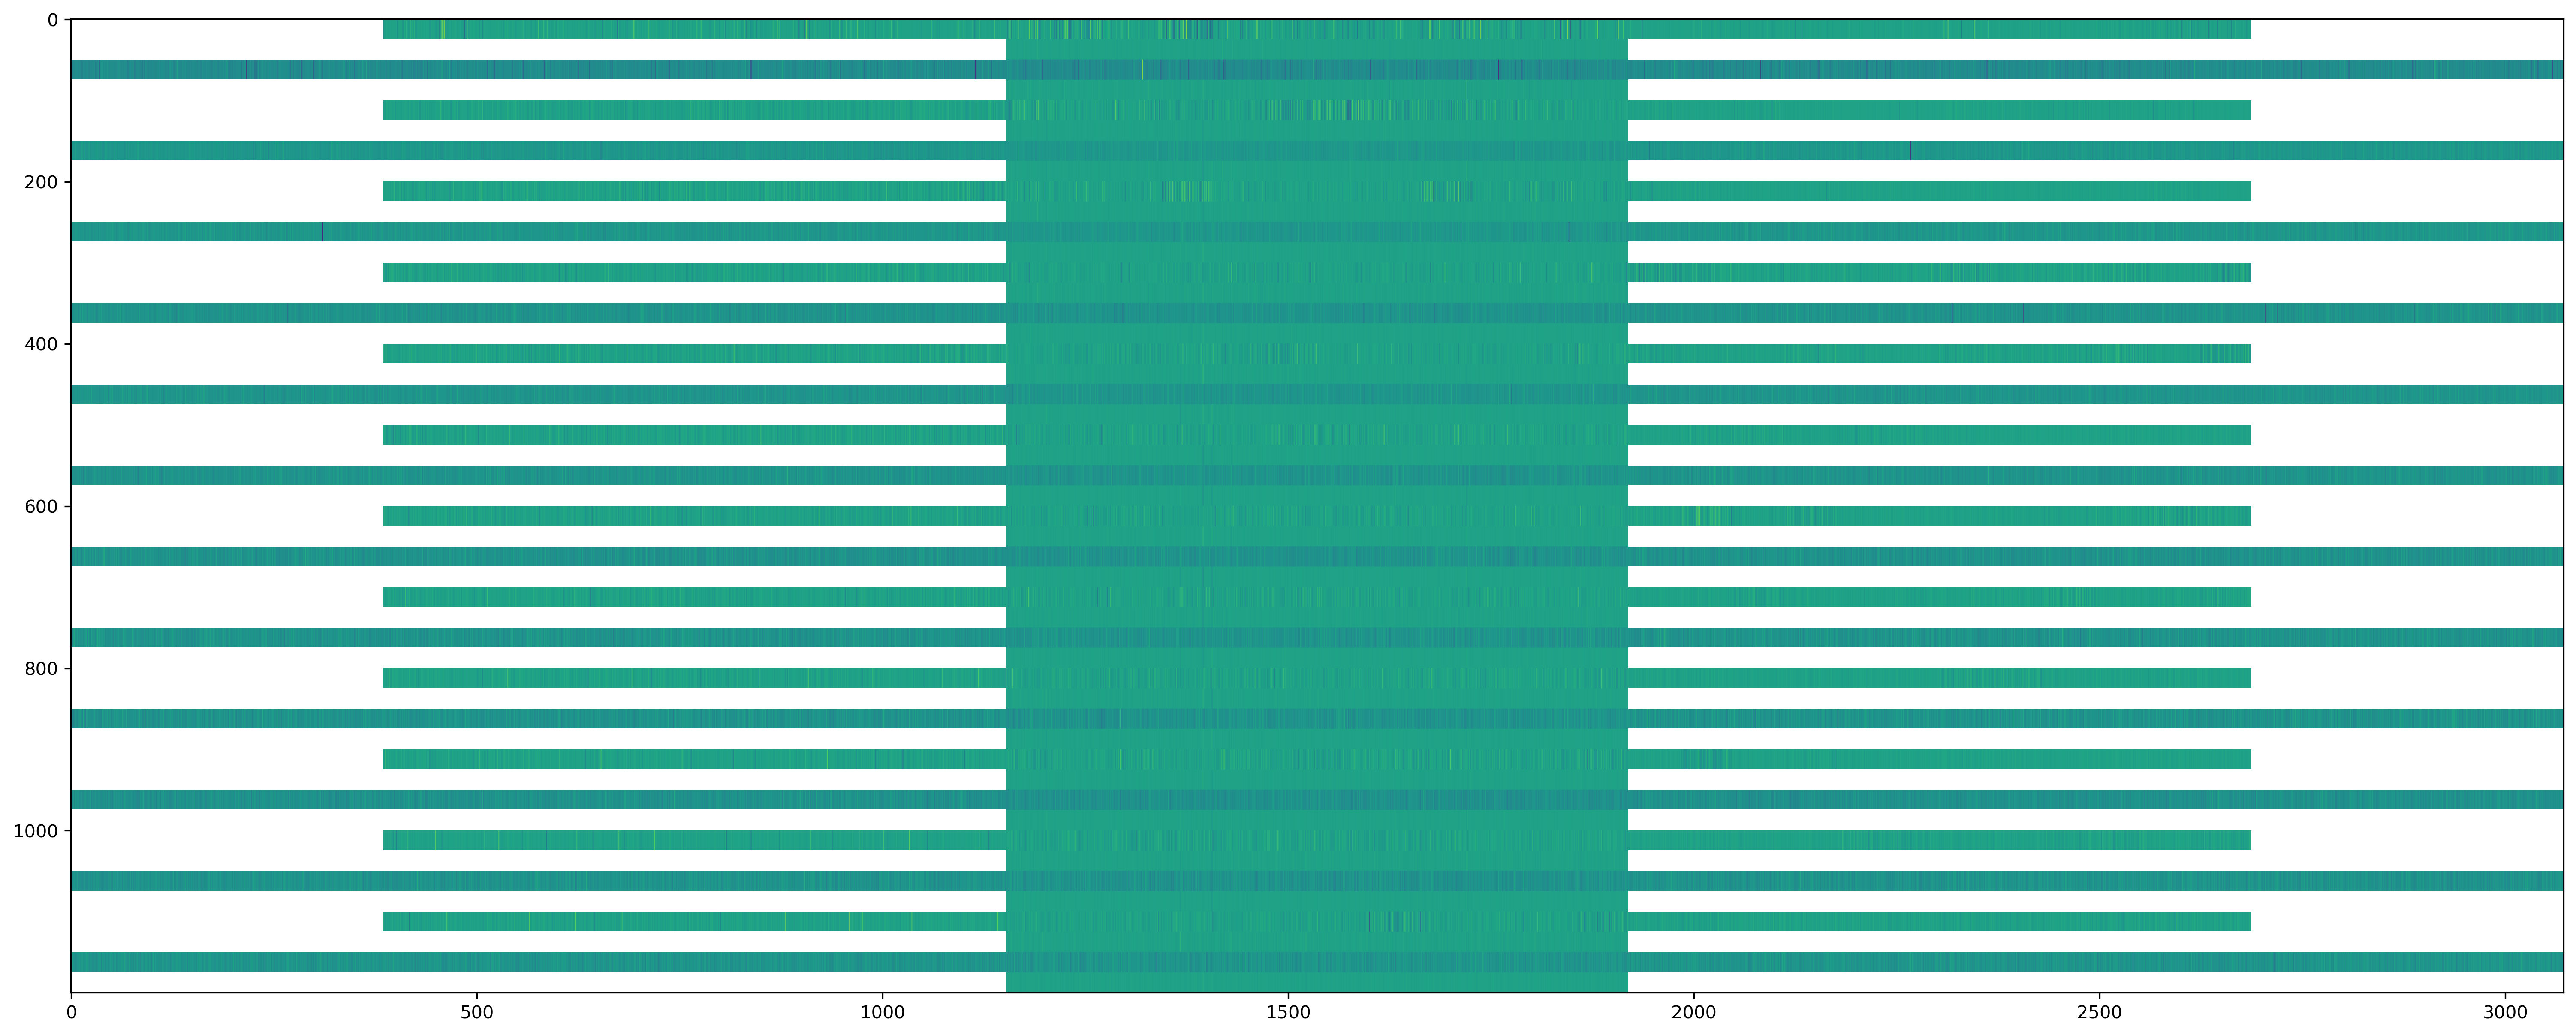

<Figure size 1920x1440 with 0 Axes>

In [15]:
fig, ax = plt.subplots(1, 1)
plt.rcParams['figure.dpi'] = 300
maxres = max(shapes)
tmp = np.zeros((len(shapes)*25, maxres))

for i, (key, shape) in enumerate(zip(keys, shapes)):
    pad = (maxres - shape) // 2
    tmp[25*i:25*i+25, pad:shape+pad] = activations[key][i]
    if pad > 0:
        tmp[25*i:25*i+25, :pad] = np.nan
        tmp[25*i:25*i+25, -pad:] = np.nan

ax.imshow(tmp)

fig.set_figheight(10)
fig.set_figwidth(25)

plt.show()
plt.clf()

# Computing the Distributions of Activation States

In [16]:

def batch_histogram(data_tensor, bins=10, bin_edges=None, interval=None):
    """
    computes a 1d histogram for each position in the last dimension of the tensor over all 
    values in that position over the flattened first k-1 dimensions, e.g activations of neurons
    in a layer over a batch of samples
    """

    data_tensor = data_tensor.flatten(0, -2)

    mind, maxd = (data_tensor.min(), data_tensor.max()) if interval is None else interval

    if bin_edges is None:
        bin_edges = (torch.arange(1, bins) - mind) / (maxd - mind)

    nc = len(bin_edges) + 1

    hist = torch.zeros((data_tensor.shape[-1], nc), dtype=data_tensor.dtype, device=data_tensor.device)

    hist[..., 0] += (data_tensor < bin_edges[0]).type(torch.int32).sum(0)

    for i in tqdm(range(len(bin_edges) - 1)):
        hist[..., i+1] += ((data_tensor >= bin_edges[i])*(data_tensor < bin_edges[i + 1])).type(torch.int32).sum(0)

    hist[..., -1] += (data_tensor >= bin_edges[-1]).type(torch.int32).sum(0)

    return hist, bin_edges


class Histogram:
    def __init__(self, bins, interval, density = False):
        self.bins = bins
        self.interval = interval
        self.histogram = None
        self.bin_edges = None

    def __call__(self, array):
        if self.histogram is None:
            self.histogram, self.bin_edges = batch_histogram(array, self.bins, interval=self.interval)
        else:
            hist, bin_edges = batch_histogram(array, self.bins, interval=self.interval)
            assert torch.equal(self.bin_edges, bin_edges), 'bin edges missmatch'
            self.histogram += hist

def hist_batch(hist, batch):
    hist(batch)
    return hist

In [17]:
activation_histogram = Histogram(1000, (-30, 30))

activation_histogram = hist_batch(activation_histogram, activations[keys[0]].to(0))

  0%|          | 0/998 [00:00<?, ?it/s]

100%|██████████| 998/998 [00:00<00:00, 30230.86it/s]


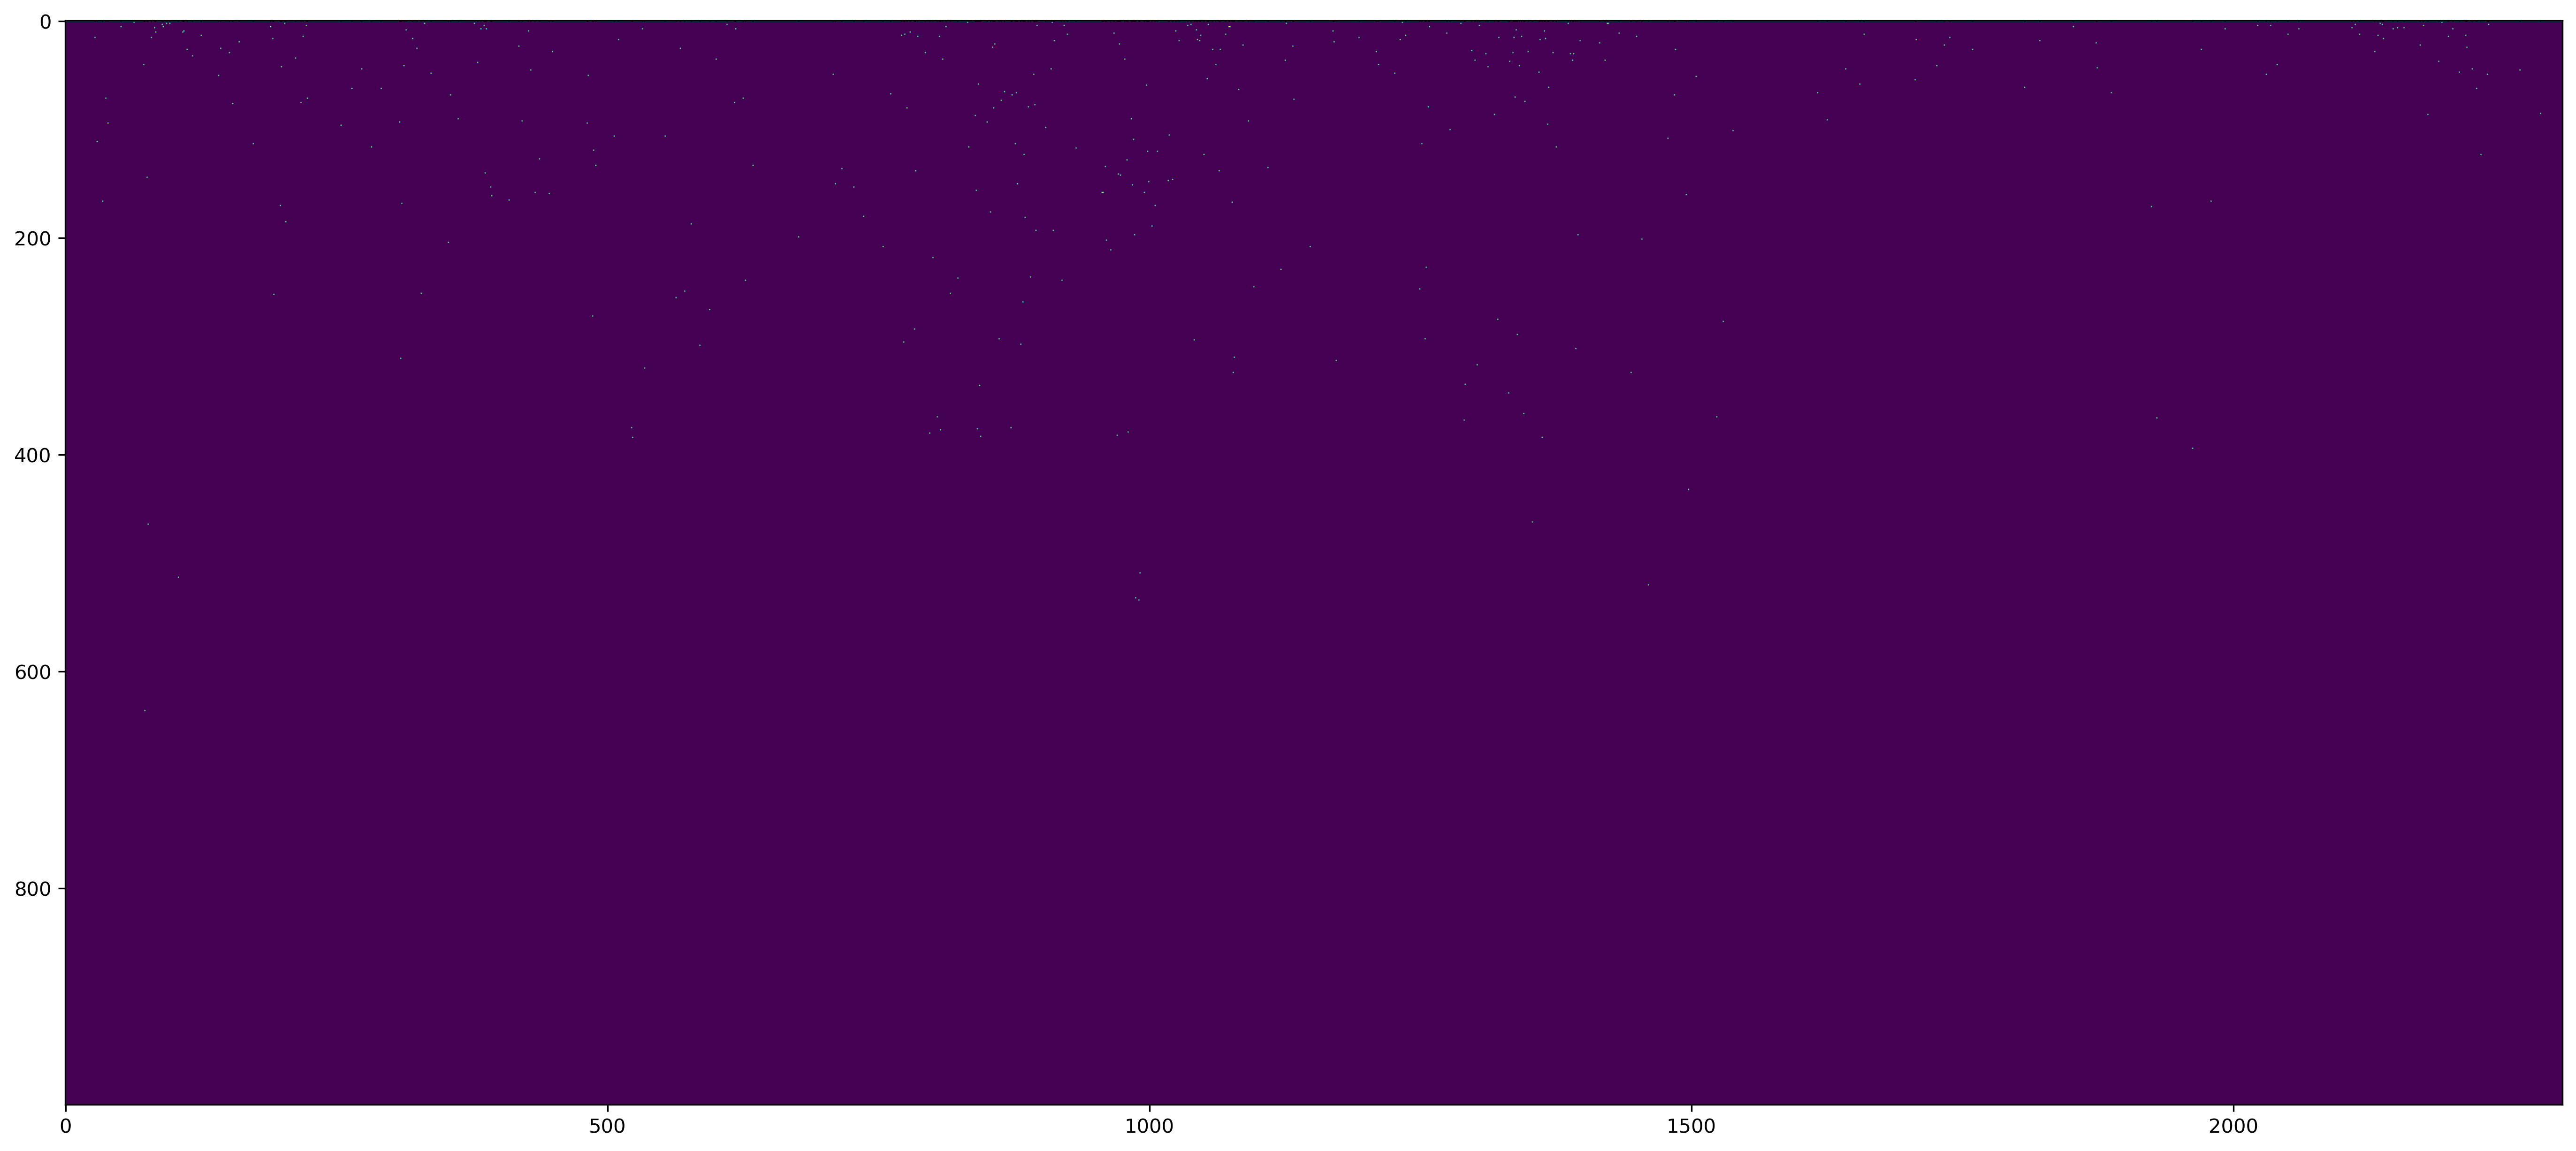

<Figure size 1920x1440 with 0 Axes>

In [18]:
hist = activation_histogram.histogram.cpu()

fig, ax = plt.subplots(1, 1)
plt.rcParams['figure.dpi'] = 300
maxres = hist.shape[0]
tmp = np.zeros((hist.shape[1], maxres))

tmp = hist.permute(1, 0)

ax.imshow(tmp)

fig.set_figheight(10)
fig.set_figwidth(25)

plt.show()
plt.clf()

In [19]:
activation_states = torch.cat([activations[key].flatten(1, -1) for key in keys], -1)

In [20]:
import sys
# 22 gigabytes at a float16 if we use all tokens, 85 MB for the class token only
sys.getsizeof(activation_states)+ torch.numel(activation_states)*activation_states.element_size()
# so, at this precision we can get roughly 2500 activation states into 1TB of RAM

84934736

#### Coping with massive activation states

In their paper the authors of CCS take only the activations for the last token in the sequence.  This is strange to me as it seems like a cost-saving measure that is poorly motivated.  For vision transformers with registers it may make sense to take only the register tokkens, but otherwise it is unclear how one could capture the global activation state without intermediate representations of spatial features.  Still, they also use very few samples and thus have no indication for how they would solve the problem that the samples are massive.

Dimensionality reduction seems natural, though if the goal is to perform model compression or knowledge extraction we will have to consider very careful the ways in which we choose to reduce the dimension so that we can maintain the performance of the model and the fidelity of the knowledge.

# Reducing the Dimension of Activation States with UMAP

In [ ]:
from umap_pytorch import PUMAP_DDP
# the 'graph' used for umap is scipy.sparse.coo_matrix((vals, (rows, cols)), shape=(X.shape[0], X.shape[0]))
# where each position is a "membership strength" which is clearly the inverse of a distance.
"""
each row is
    a local fuzzy simplicial set, with a membership strength for the
    1-simplex to each other data point.

from umap.umap_.fuzzy_simplicial_set
-----------------------------------------------------------------------------------------

sigmas, rhos = umap.umap_.smooth_knn_dist(distances, k, n_iter=64, local_connectivity=1.0, bandwidth=1.0)

    Parameters
    ----------
    distances: array of shape (n_samples, n_neighbors)
        Distances to nearest neighbors for each sample. Each row should be a
        sorted list of distances to a given samples nearest neighbors.

    k: float
        The number of nearest neighbors to approximate for.

    n_iter: int (optional, default 64)
        We need to binary search for the correct distance value. This is the
        max number of iterations to use in such a search.

    local_connectivity: int (optional, default 1)
        The local connectivity required -- i.e. the number of nearest
        neighbors that should be assumed to be connected at a local level.
        The higher this value the more connected the manifold becomes
        locally. In practice this should be not more than the local intrinsic
        dimension of the manifold.

from umap.umap_.compute_membership_strengths
-----------------------------------------------------------------------------------------

    bandwidth: float (optional, default 1)
        The target bandwidth of the kernel, larger values will produce
        larger return values.

         elif knn_dists[i, j] - rhos[i] <= 0.0 or sigmas[i] == 0.0:
                val = 1.0
            else:
                val = np.exp(-((knn_dists[i, j] - rhos[i]) / (sigmas[i])))

            rows[i * n_neighbors + j] = i
            cols[i * n_neighbors + j] = knn_indices[i, j]
            vals[i * n_neighbors + j] = val


    return rows, cols, vals

the value we need to compute
-----------------------------------------------------------------------------------------
graph = scipy.sparse.coo_matrix((vals, (rows, cols)), shape=(X.shape[0], X.shape[0]))
"""

#### The first question to ask is "what are we reducing?"

If our goal is to compress an existing model while retaining performance and usability, then our options for dimensionality reduction of the activation states is much lower.  If our goal is discovering the knowledge within the knowledge then the application is not tied to a specific architecture.

UMAP dimensionality reduction has two components:
- a distance metric in the underlying space
- an adjcentcy matrix in the 



# Using Activation State Dimensionality Reduction for Model Compression

#### Reducing the Neurons in each Layer

Using UMAP to reduce the number of neurons in each layer is fairly straightforward.  We will reduce the dimensionality of the activation state using parametric UMAP, we will cluster the resulting low-dimensional vectors and use the reconstructions of the centroids as the new neurons.  If we are careful about the extent to which we reduce each layer, respect the shapes of skip connections, and aggregate inputs in subsequent layers appropriately then the function of the network is relatively unimpacated.

In order to successfully create reconstructions that serve the purpose of the original neurons we have to correctly define the adjacentcy matrix.  In this case it should be some correlation metric between the activation of each neuron.  This metric will impact how the inputs to future neurons should be activated.  If we use the linear correlation matrix as the adjacentcy matrix then we know what the centroid means - it is the average of the correlated activations, so we compute the mean of the input weights.

In [ ]:
rand = torch.rand(3, 3)
rand[torch.where(rand < 0.5)] = 0
rand = rand.to_sparse()
rand @ torch.eye(3) # is dense
torch.eye(3) @ rand # is dense
torch.eye(3).to_sparse() @ rand # is sparse

# rand.to_sparse(sparse_dim=1) # only sparsify across one dimension, useful for removing neurons

#### Sparsity as the modality for state reduction

While sparsity is a flexible way to reduce the dimensionality of the activation state, we will have to sparsify the input (which will result in a performance penalty of some amount) initially as well as sparsifying the weight matrices.  Also, while it is flexible it is likely only faster if we are removing many many neurons and in many cases we know how to remove them while simplifying the dense operation.

#### Architecture-agnostic activation state reduction

If our goal is simply to reduce 